In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate
from src.interpolate import *
import jax

Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

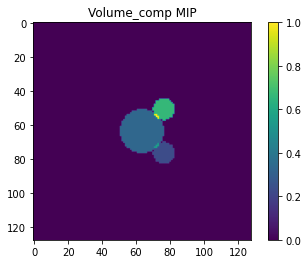

In [3]:
nx = 128
shape = np.array([nx,nx,nx])
dimensions = np.array([20,20,20])

# A volume with components
centres = np.array([[0,0,0], [2, 2, 0], [2, -2, 0]])
radii = np.array([2, 1, 1])
intensities = np.array([10,7,20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, X, Y, Z, _, _, _ = volume_fourier(jnp.fft.ifftshift(vol), dimensions)

mip_z(vol)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

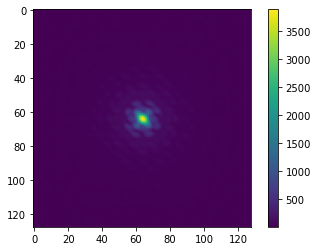

In [4]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

Get the grids and mask

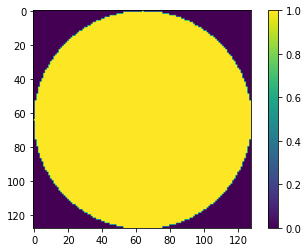

In [5]:
x_freq = X[0,:,0]
y_freq = Y[:,0,0]
z_freq = Z[0,0,:]

# Important thast the grids are not jax (aka Tracer)  objects
x_grid = np.array([x_freq[1], len(x_freq)])
y_grid = np.array([y_freq[1], len(y_freq)])
z_grid = np.array([z_freq[1], len(z_freq)])

radius = 3.2
mask = create_mask(X, Y, Z , (0,0,0),radius)

mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

Generate projections (in Fourier domain)

In [6]:
@jax.jit
def slice_func(v, angles):
    projection, _ = project(mask * v, x_grid, y_grid, z_grid, angles)
    return projection

@jax.jit
def slice_func_array(v, angles):    
    return jax.vmap(slice_func, in_axes = (None, 0))(v, angles)

In [7]:
N = 100
angles_true = jnp.array(np.random.rand(N,3))*jnp.pi*2
start = time.time()
imgs = slice_func_array(vol_fourier, angles_true)
print(time.time()-start)

1.565859079360962


In [8]:
imgs.shape

(100, 16384)

In [9]:
np.sum(mask[0])

DeviceArray(12851., dtype=float64)

Loss function given volume and angles, for one image and for many (batches of images). We have a separate loss function for each angles-image pair.

In [21]:
@jax.jit
def l2sq(x):
    return jnp.real(jnp.sum(jnp.conj(x)*x))

@jax.jit
def loss_func(v, angles, img):
    return 1/(2* nx*nx) * l2sq(slice_func(v, angles) - img)
    #return 1/(2* 1257) * l2sq(slice_func(v, angles) - img)   #1257 = number of pixels in mask at z=0


@jax.jit
def loss_func_batched(v, angles, imgs):
    return jax.vmap(loss_func, in_axes = (None, 0, 0))(v, angles, imgs)

@jax.jit
def loss_func_sum(v, angles, imgs):
    return jnp.mean(loss_func_batched(v, angles, imgs))

In [11]:
loss_func(vol_fourier, angles_true[0],imgs[0])

DeviceArray(4.34628828e-29, dtype=float64)

In [12]:
#@jax.jit
def resid(v):
    return slice_func(v,angles_true[0])-imgs[0]

@jax.jit
def myfunc(v, angles,img):
    return l2sq(slice_func(v, angles) - img)

@jax.jit
def mygrad(v):
    return jax.grad(myfunc)(v, angles_true[0], imgs[0])

In [13]:
r1 = resid(vol_fourier)

jnp.max(jnp.abs(jnp.imag(r1)))

DeviceArray(0., dtype=float64)

And the gradients of the above, with respect to angles

In [14]:
@jax.jit
def grad_loss_angles(v, angles, img):
    return jax.grad(loss_func, argnums = 1)(v, angles, img)

@jax.jit
def grad_loss_angles_batched(v, angles, imgs):
    return jax.vmap(grad_loss_angles, in_axes = (None, 0, 0))(v, angles, imgs)

In [15]:
start = time.time()
ll = loss_func_batched(vol_fourier, angles_true, imgs)
print(time.time()-start)
print(ll.shape)

1.7107818126678467
(100,)


In [ ]:
start = time.time()
dl = grad_loss_angles(vol_fourier, angles_true[0], imgs[0])
print(time.time()-start)
print(dl.shape)

In [ ]:
start = time.time()
dl = grad_loss_angles_batched(vol_fourier, angles_true, imgs)
print(time.time()-start)
print(dl.shape)

Gradients with respect to volume pixels, over all (or a batch of) images

In [20]:
@jax.jit
def grad_loss_volume(v, angles, img):
    return jax.grad(loss_func)(v, angles, img)

@jax.jit
def grad_loss_volume_batched(v, angles, imgs):
    return 1/N * jnp.sum(jax.vmap(grad_loss_volume, in_axes = (None, 0, 0))(v, angles, imgs), axis=0)

@jax.jit
def grad_loss_volume_sum(v, angles, imgs):
    return jnp.conj(jax.grad(loss_func_sum)(v, angles, imgs))


In [17]:
start = time.time()
ll = grad_loss_volume(vol_fourier, angles_true[0], imgs[0])
print(time.time()-start)
print(ll.shape)

2.171996831893921
(128, 128, 128)


Doing the below with N large enough (e.g. 1000) makes it run out of memory (trying to allocate >200GB)

In [18]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vol_fourier, angles_true[idx], imgs[idx])
print(time.time()-start)
print(ll.shape)

4.349561929702759
(128, 128, 128)


## Gradient descent with respect to angles

In [ ]:
alpha = 0.00000001
a = jnp.array(np.random.rand(N, 3)*np.pi*2)
a = jnp.mod(a, 2*jnp.pi)
#a = angles_true + 0.01*a
N_iter = 10

for i in range(N_iter):
        
    if jnp.mod(i,100) == 0:
    #print(i)
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(vol_fourier, a, imgs))))
        
    a = a - alpha * jnp.conj(grad_loss_angles_batched(vol_fourier, a, imgs))
    
a = jnp.mod(a, 2*jnp.pi)


    
max_err = jnp.mean(jnp.abs(a - angles_true))
print("mean(a-a_true) = " + str(max_err))

In [ ]:
max_err = jnp.max(jnp.abs(a - angles_true))
print("max(a-a_true) = " + str(max_err))

## Optimization with respect to volume

In [ ]:
nx 

In [ ]:
zero.dtype

In [ ]:
from src.algorithm import conjugate_gradient

v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))*jnp.max(jnp.abs(imgs[0])) * mask
N_iter = 10
zero = jnp.zeros(vol_fourier.shape)*1j
Ab = - jnp.conj(grad_loss_volume_sum(zero, angles_true, imgs))
AA = lambda vv : jnp.conj(grad_loss_volume_sum(vv, angles_true, imgs)) + Ab
#- jnp.conj(grad_loss_volume_sum(zero, angles_true, imgs))


vcg, max_iter = conjugate_gradient(AA, Ab, v0, N_iter, verbose = True)
   
#print("Final loss function = ", jnp.mean(loss_func_sum(vcg, angles_true, imgs)))
print("Relative error = ", jnp.max(jnp.abs((vcg - vol_fourier)/jnp.max(vol_fourier))))

In [ ]:
jnp.max(jnp.abs(AA(vcg) + AA(vcg) - AA(2*vcg)))

In [ ]:
jnp.max(jnp.abs(AA(vol_fourier) + AA(vol_fourier) - AA(2*vol_fourier)))

In [19]:

v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))*jnp.max(jnp.abs(imgs[0])) * mask
#v0 = vol_fourier + 0.1*v * mask
#alpha = 1000000 # this alpha works well for full 128 x 128 x 128 volume with mask
alpha = 100000000
batch_size = 2
N_iter = 1000 * 20 
#N_iter = 1000 

v = v0
for i in range(N_iter):
    
    idx = np.random.default_rng().choice(N, size=batch_size, replace = False)
    
    if jnp.mod(i,100) == 0:
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(v, angles_true[idx], imgs[idx]))))

    v = v - alpha * jnp.conj(grad_loss_volume_batched(v, angles_true[idx], imgs[idx]))
    
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

Iter 0: mean loss = 3575151.5939241266


KeyboardInterrupt: 

In [ ]:
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

In [ ]:
loss_imgs = loss_func_batched(v, angles_true, imgs)
plt.plot(loss_imgs)

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift((v-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

In [ ]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift((vol_fourier)))) ; plt.colorbar()

In [ ]:
jnp.max(jnp.abs(jnp.imag(jnp.fft.fftshift(jnp.fft.ifftn(v*mask)))))

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier*mask - v*mask)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

And the error with the high freq volume

In [ ]:
mip_z(jnp.abs(vol-jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')